In [1]:
import numpy as np
import scipy.sparse as sp
import sknetwork as sn
import numba
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import f1_score as F1
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

from abcd_graph import ABCDGraph, ABCDParams
from partition_sknetwork import ECG
from tqdm import tqdm
import CAS
import community_evaluation as ce

In [2]:
# We tend to get divide by 0 warnings, but they are corretly set to inf
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
@numba.njit
def _get_cas_work(
    labels,
    labels_indptr,
    labels_indices,
    adjacency_indptr,
    adjacency_indices,
    adjacency_data,
    cas,
):
    node_labels = CAS.cas_._make_node_label_sets(labels_indptr, labels_indices, len(adjacency_indptr)-1)
    graph_volume = np.sum(adjacency_data)
    # Cache label volumes
    label_volumes = np.zeros(np.max(labels)+1, dtype="float32")
    for node, nl in enumerate(node_labels):
        degree = CAS.cas_._get_degree(node, adjacency_indptr, adjacency_indices, adjacency_data)
        for label in nl:
            label_volumes[label] += degree
    assert graph_volume > 0
    label_volumes /= graph_volume

    # Compute Scores
    scores = np.empty(len(labels))
    for i, label in enumerate(labels):
        scores[i] = cas(
            i,
            label,
            label_volumes[label],
            node_labels,
            adjacency_indptr,
            adjacency_indices,
            adjacency_data,
        )
    return scores


def get_cas(labels, adjacency, cas):
    # Assume labels is a numpy array of a partition
    # return a numpy array with the cas score to each label
    labels_matrix = CAS.cas_.labels_array_to_matrix(labels).tocsc()
    return _get_cas_work(
        labels,
        labels_matrix.indptr,
        labels_matrix.indices,
        adjacency.indptr,
        adjacency.indices,
        adjacency.data,
        cas
    )


def cluster_f1s(labels, predict):
    if all(predict < 0):
        return 0
    n = len(predict)

    if not sp.issparse(labels):
        labels_indptr, labels_indices, labels_data = CAS.cas_._labels_array_to_matrix(
            labels
        )
        labels = sp.csr_matrix(
            (labels_data, labels_indices, labels_indptr),
            shape=(len(labels_indptr) - 1, n),
            dtype="bool",
        )
        labels.data[:] = True  # Sometime some entries are flipped to false, don't know why.

    predict_indptr, predict_indices, predict_data = CAS.cas_._labels_array_to_matrix(
        predict
    )
    predict = sp.csr_matrix(
        (predict_data, predict_indices, predict_indptr),
        shape=(len(predict_indptr) - 1, n),
        dtype="bool",
    )
    predict.data[:] = (
        True  # Sometime some entries are flipped to false, don't know why.
    )

    label_props = np.asarray(labels.sum(axis=1)).reshape(-1)
    label_props = label_props / np.sum(label_props)
    predict_props = np.asarray(predict.sum(axis=1)).reshape(-1)
    predict_props = predict_props / np.sum(predict_props)

    overlap = predict.astype("float64") * labels.transpose().astype("float64")
    precision = overlap.multiply(1 / predict.sum(axis=1))
    recall = overlap.multiply(1 / labels.sum(axis=1).reshape(-1))
    denom = precision + recall
    denom.data = 1 / denom.data
    f1 = 2 * precision.multiply(recall).multiply(denom)
    predict_f1 = f1.max(axis=1).toarray().reshape(-1)
    predict_average = np.sum(predict_f1 * predict_props)

    labels_f1 = f1.max(axis=0).toarray().reshape(-1)
    labels_average = np.sum(labels_f1 * label_props)

    return 2 / (1 / predict_average + 1 / labels_average)

100%|██████████| 250/250 [09:07<00:00,  2.19s/it]


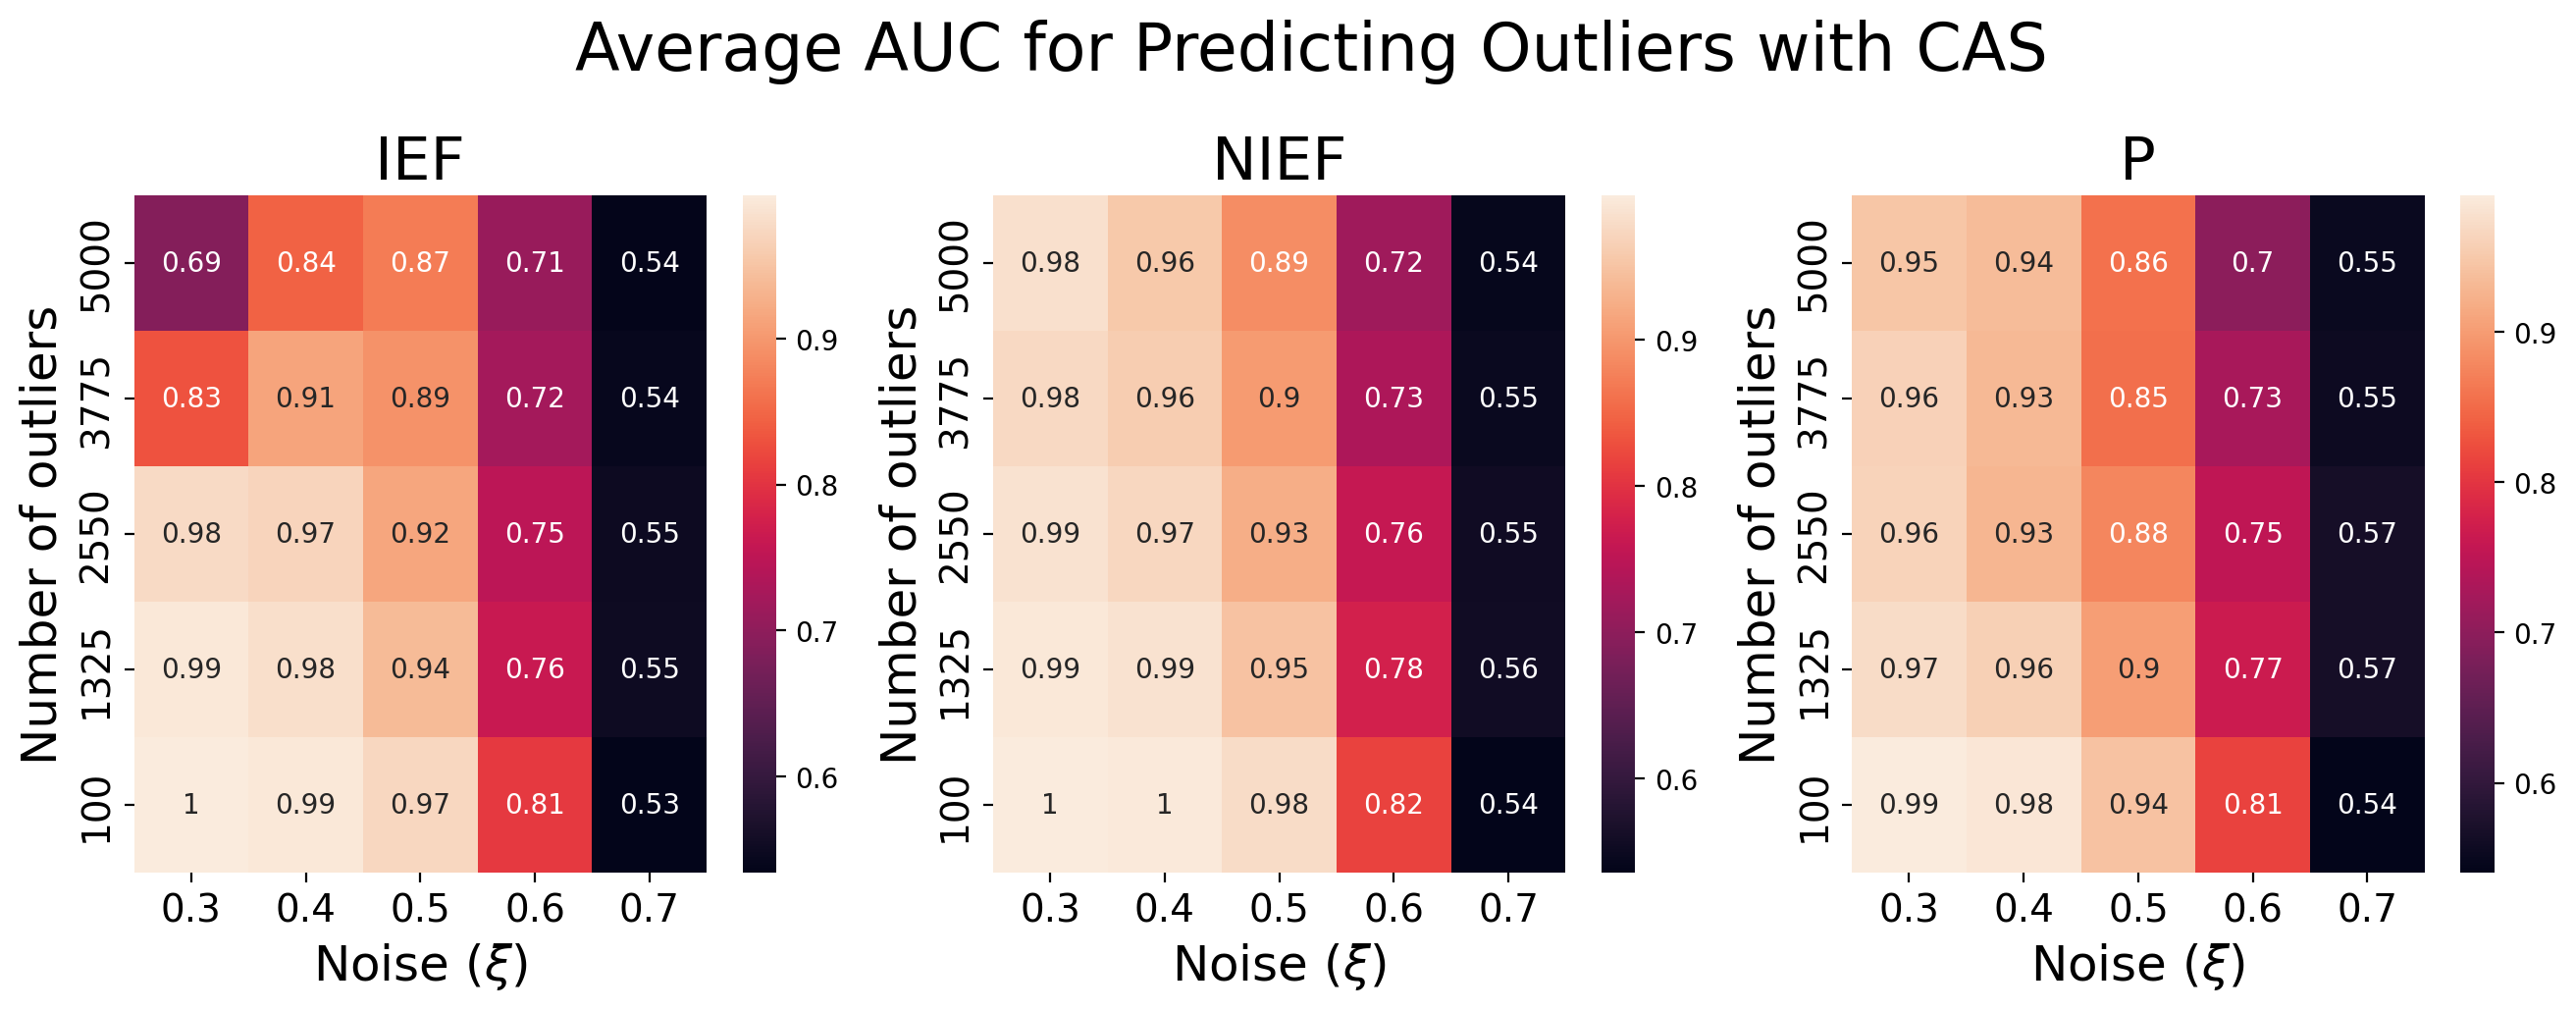

In [16]:
## For each CAS, make a heatmap of average AUC score
REP = 10
n = 10000
XIS = np.round(np.linspace(0.3, 0.7, 5), 3)
NOUTS = np.linspace(100, 5000, 5, dtype="int64")

ief_aucs = np.empty((len(XIS), len(NOUTS), REP))
nief_aucs = np.empty((len(XIS), len(NOUTS), REP))
p_aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS) * len(NOUTS) * REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                params = ABCDParams(
                    vcount=n,
                    gamma=2.5,
                    min_degree=5,
                    max_degree=int(n**0.5),
                    beta=1.5,
                    min_community_size=25,
                    max_community_size=int(n**0.767),
                    xi=xi,
                    num_outliers=nout,
                )
                G = ABCDGraph(params)
                G.build()
                adjacency = G.exporter.to_sparse_adjacency_matrix()
                labels = np.array(
                    [i for i, com in enumerate(G.communities) for _ in com.vertices]
                )
                is_not_outlier = labels != np.max(labels)
                predict = ECG().fit_predict(adjacency)
                iefs = get_cas(
                    predict,
                    adjacency,
                    CAS.cas_._ief,
                )
                ief_aucs[i, j, k] = AUC(is_not_outlier, iefs)
                niefs = get_cas(
                    predict,
                    adjacency,
                    CAS.cas_._nief,
                )
                nief_aucs[i, j, k] = AUC(is_not_outlier, niefs)
                ps = get_cas(
                    predict,
                    adjacency,
                    CAS.cas_._p,
                )
                p_aucs[i, j, k] = AUC(is_not_outlier, ps)
                pbar.update()

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(top=0.8)  # Make room for suptitle

sns.heatmap(
    np.flip(np.mean(ief_aucs, axis=2), axis=1).T,
    xticklabels=XIS,
    yticklabels=NOUTS[::-1],
    annot=True,
    ax=axs[0],
)
axs[0].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[0].set_ylabel("Number of outliers", fontsize=18)
axs[0].tick_params(labelsize=14)
axs[0].set_title("IEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(nief_aucs, axis=2), axis=1).T,
    xticklabels=XIS,
    yticklabels=NOUTS[::-1],
    annot=True,
    ax=axs[1],
)
axs[1].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[1].set_ylabel("Number of outliers", fontsize=18)
axs[1].tick_params(labelsize=14)
axs[1].set_title("NIEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(p_aucs, axis=2), axis=1).T,
    xticklabels=XIS,
    yticklabels=NOUTS[::-1],
    annot=True,
    ax=axs[2],
)
axs[2].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[2].set_ylabel("Number of outliers", fontsize=18)
axs[2].tick_params(labelsize=14)
axs[2].set_title("P", fontsize=22)

plt.suptitle("Average AUC for Predicting Outliers with CAS", fontsize=24, y=0.98)
fig.set_dpi(200)
# fig.savefig("outlier-aucs.png", bbox_inches="tight")

## Compute the Outlier F1 Score vs. Threshold for 9 ABCD+o graphs

In [95]:
REP = 3
n = 10000
NOUTS = [100, 1000, 4000]
XIS = [0.4, 0.5, 0.6]
ief_thresholds = np.linspace(0.1, 0.8, 11)
p_thresholds = np.linspace(0.8, 0.999, 11)

ief_f1s = np.empty((len(NOUTS), len(XIS), len(ief_thresholds), REP))
nief_f1s = np.empty((len(NOUTS), len(XIS), len(ief_thresholds), REP))
p_f1s = np.empty((len(NOUTS), len(XIS), len(p_thresholds), REP))

with tqdm(total=len(NOUTS) * len(XIS) * REP) as pbar:
    for i, nout in enumerate(NOUTS):
        for j, xi in enumerate(XIS):
            for k in range(REP):
                params = ABCDParams(
                    vcount=n,
                    gamma=2.5,
                    min_degree=5,
                    max_degree=int(n**0.5),
                    beta=1.5,
                    min_community_size=50,
                    max_community_size=int(n**0.767),
                    xi=xi,
                    num_outliers=nout,
                )
                G = ABCDGraph(params)
                G.build()
                adjacency = G.exporter.to_sparse_adjacency_matrix()
                labels = np.array(
                    [i for i, com in enumerate(G.communities) for _ in com.vertices]
                )
                is_outlier = labels == np.max(labels)
                predict = ECG().fit_predict(adjacency)

                for l, thresh in enumerate(ief_thresholds):
                    cas_predict = CAS.CASPostProcesser(
                        score="ief", threshold=thresh
                    ).fit_predict(predict, adjacency)
                    ief_f1s[i, j, l, k] = F1(is_outlier, cas_predict == -1)

                for l, thresh in enumerate(ief_thresholds):
                    cas_predict = CAS.CASPostProcesser(
                        score="nief", threshold=thresh
                    ).fit_predict(predict, adjacency)
                    nief_f1s[i, j, l, k] = F1(is_outlier, cas_predict == -1)

                for l, thresh in enumerate(p_thresholds):
                    cas_predict = CAS.CASPostProcesser(
                        score="p", threshold=thresh
                    ).fit_predict(predict, adjacency)
                    p_f1s[i, j, l, k] = F1(is_outlier, cas_predict == -1)

                pbar.update()

100%|██████████| 27/27 [15:27<00:00, 34.35s/it]


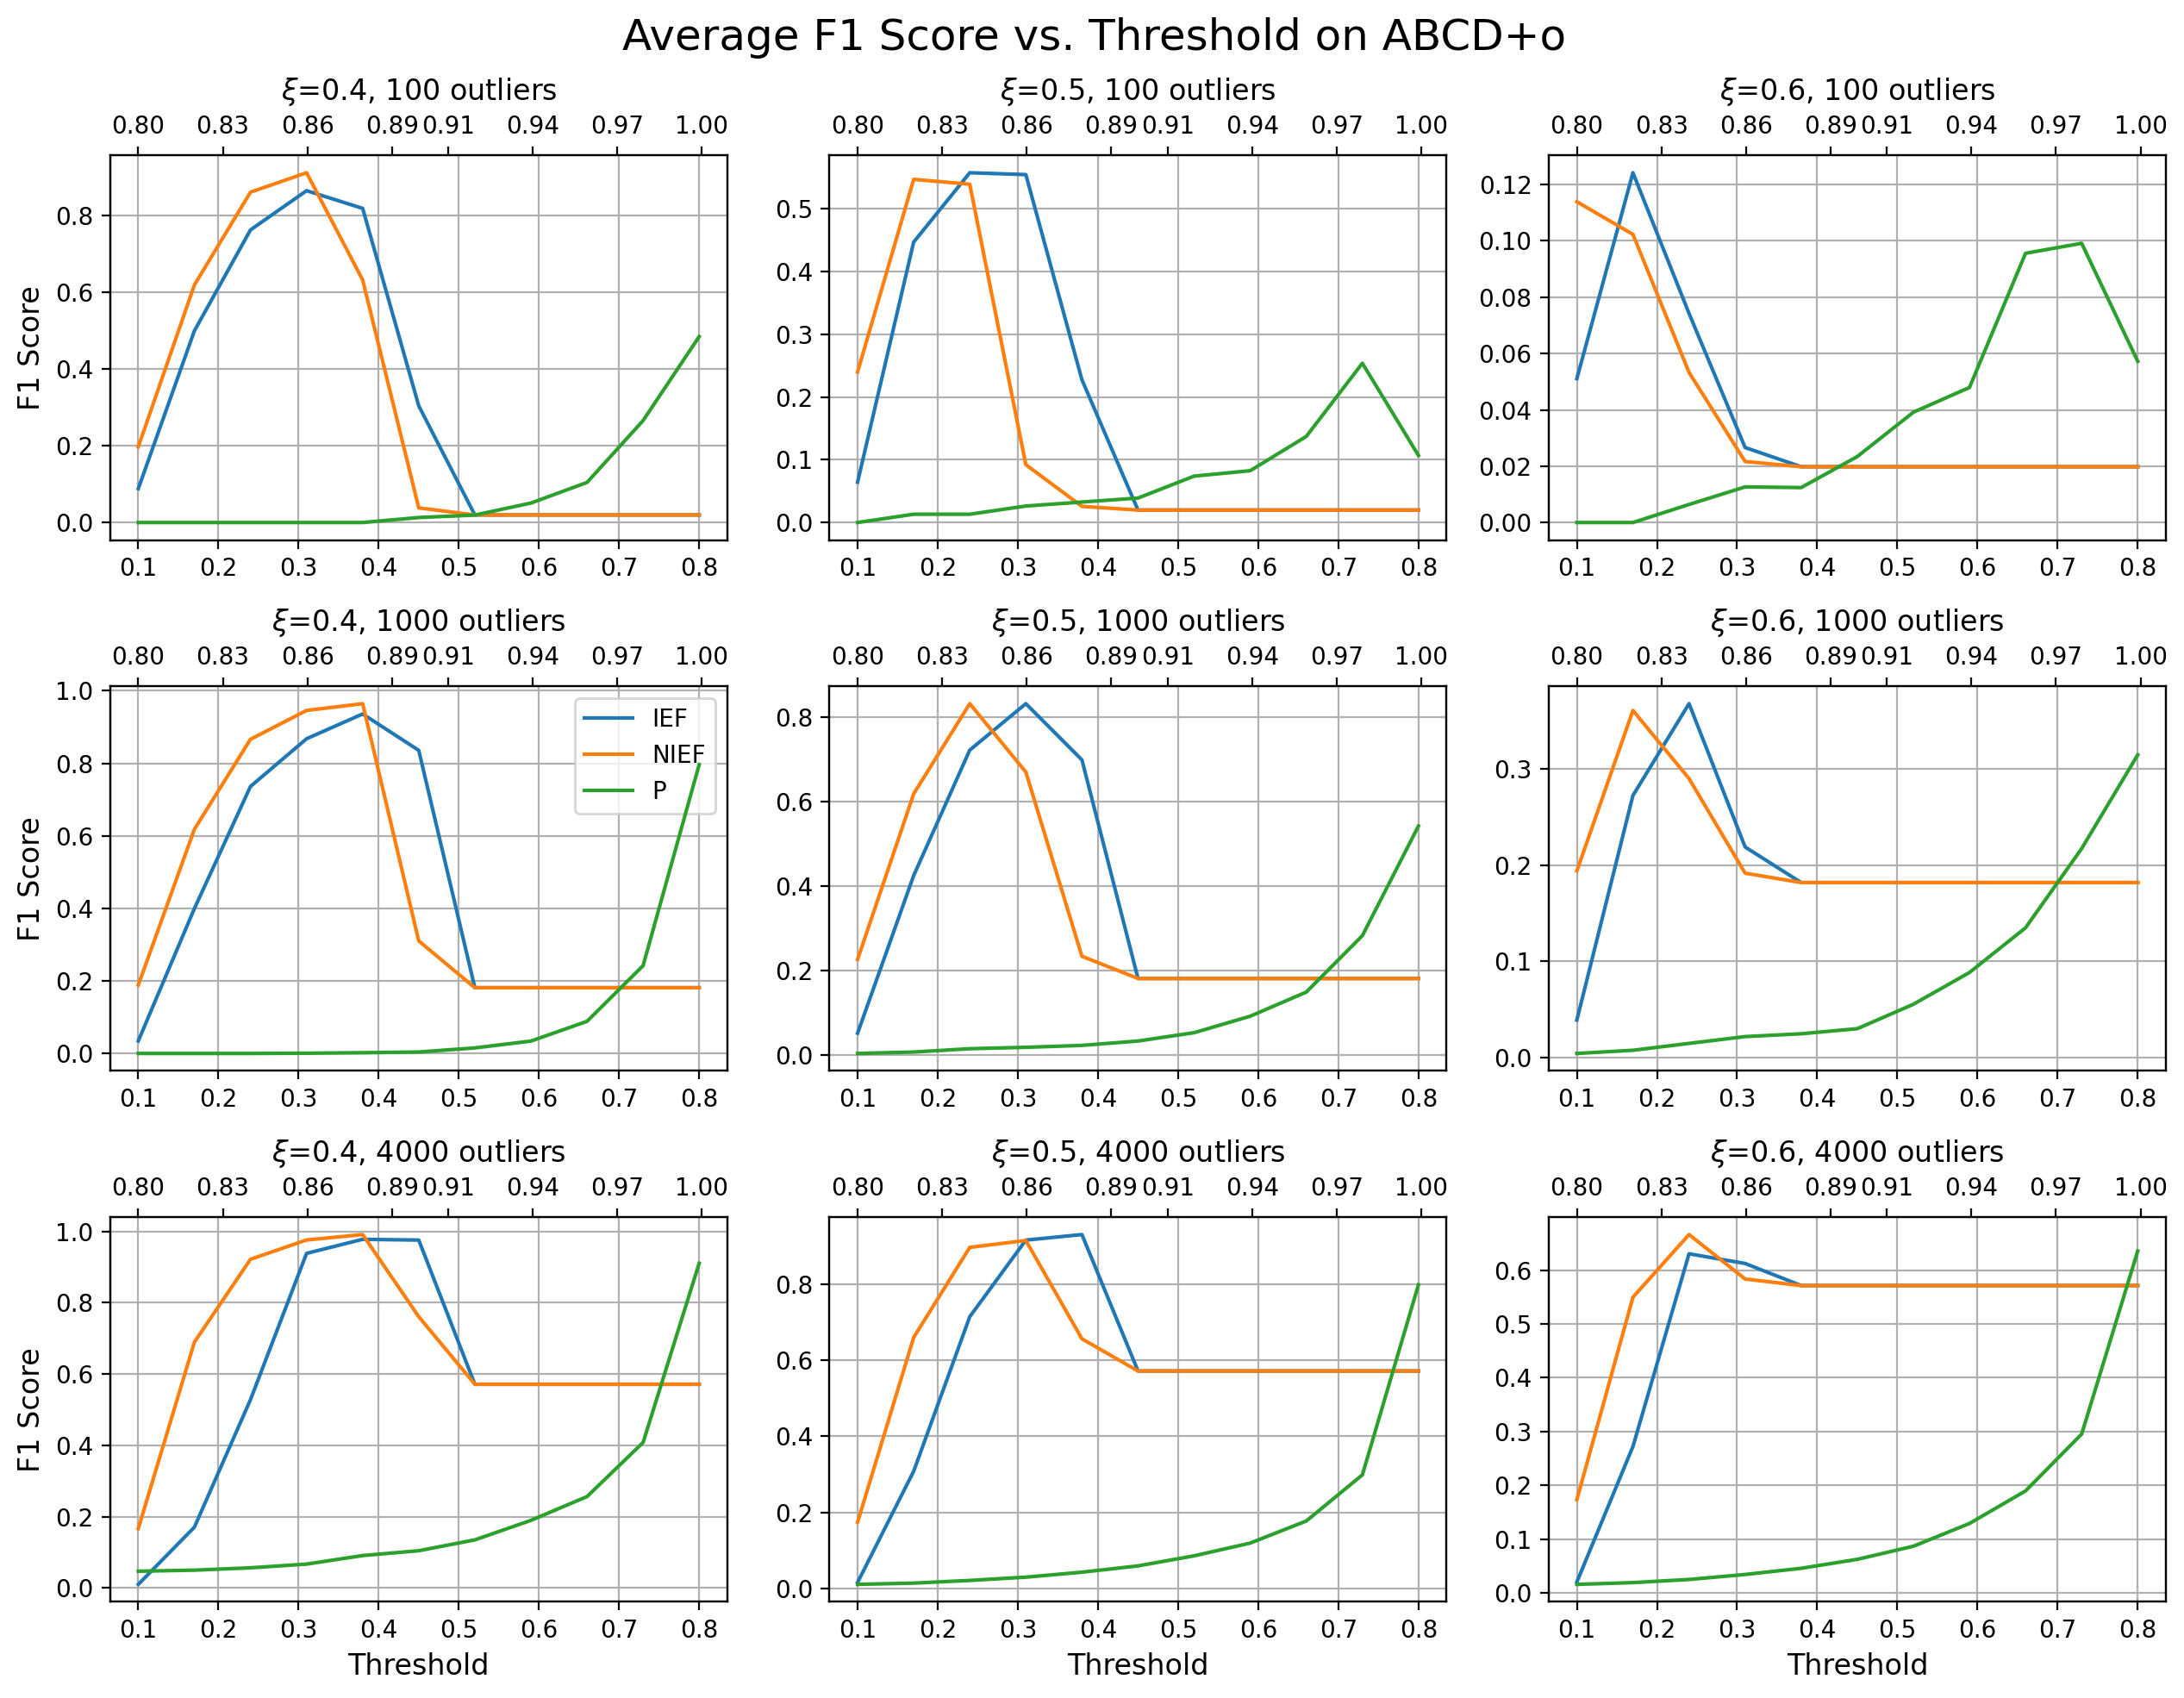

In [98]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]


fig, axs = plt.subplots(3, 3)
for i, nout in enumerate(NOUTS):
    for j, xi in enumerate(XIS):
        lines = []
        twy = axs[i, j].twiny()

        lines += axs[i, j].plot(
            ief_thresholds,
            np.mean(ief_f1s[i, j, :, :], axis=1),
            label="IEF",
            c=colors[0],
        )
        lines += axs[i, j].plot(
            ief_thresholds,
            np.mean(nief_f1s[i, j, :, :], axis=1),
            label="NIEF",
            c=colors[1],
        )
        lines += twy.plot(
            p_thresholds, np.mean(p_f1s[i, j, :, :], axis=1), label="P", c=colors[2]
        )
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 8
        ief_ticks = np.linspace(np.min(ief_thresholds), np.max(ief_thresholds), n_ticks)
        axs[i, j].set_xticks(ief_ticks)
        p_ticks = np.round(np.linspace(np.min(p_thresholds), 1, n_ticks), 2)
        twy.set_xticks(p_ticks)

        axs[i, j].grid()
        axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("F1 Score", fontsize=12)
axs[1, 0].set_ylabel("F1 Score", fontsize=12)
axs[2, 0].set_ylabel("F1 Score", fontsize=12)
axs[2, 0].set_xlabel("Threshold", fontsize=12)
axs[2, 1].set_xlabel("Threshold", fontsize=12)
axs[2, 2].set_xlabel("Threshold", fontsize=12)
axs[1, 0].legend(lines, labels)
plt.suptitle(f"Average F1 Score vs. Threshold on ABCD+o", fontsize=18)

fig = plt.gcf()
fig.set_size_inches(12.8, 10)
fig.set_dpi(200)
fig.tight_layout()

## Fix 10% (?) outliers xi=0.5, make a row of 3 line graphs.
Threshold vs AMI (remove outliers), Theshold vs. % Outliers, Threshold vs. Outlier F1
Hopefully can show clear trend of higher threshold => less wrong and more pruned

In [17]:
REP = 10
n = 10000
ief_thresholds = np.linspace(0.1, 0.5, 20)
p_thresholds = np.linspace(0.8, 0.999, 20)

# Store (Cluster F1s, % Outlier, F1) in first axis, theshold in second axis, REP in third axis
ief = np.zeros((2, 3, len(ief_thresholds), REP))
nief = np.zeros((2, 3, len(ief_thresholds), REP))
p = np.zeros((2, 3, len(p_thresholds), REP))
ecg = np.zeros((2, 3, len(ief_thresholds), REP))

with tqdm(total=len(ief_thresholds) * REP) as pbar:
    for i in range(REP):
        params = ABCDParams(
            vcount=n,
            gamma=2.5,
            min_degree=5,
            max_degree=int(n**0.5),
            beta=1.5,
            min_community_size=50,
            max_community_size=int(n**0.767),
            xi=0.55,
            num_outliers=int(n / 5),
        )
        G = ABCDGraph(params)
        G.build()
        adjacency = G.exporter.to_sparse_adjacency_matrix()
        labels = np.array(
            [i for i, com in enumerate(G.communities) for _ in com.vertices]
        )
        is_outlier = labels == np.max(labels)
        ecgo = ECG()
        predict = ecgo.fit_predict(adjacency)

        for j, (t1, t2) in enumerate(zip(ief_thresholds, p_thresholds)):
            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t1).fit_predict(
                predict, adjacency
            )
            ief[0, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            ief[0, 2, j, i] = F1(is_outlier, cas_predict == -1)
            neither_outlier = np.bitwise_and(~is_outlier, cas_predict >= 0)
            if np.sum(neither_outlier) > 0:
                ief[0, 0, j, i] = cluster_f1s(labels[neither_outlier], cas_predict[neither_outlier])
            else:
                ief[0, 0, j, i] = 1

            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t1, max_rounds=1).fit_predict(
                predict, adjacency
            )
            ief[1, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            ief[1, 2, j, i] = F1(is_outlier, cas_predict == -1)
            neither_outlier = np.bitwise_and(~is_outlier, cas_predict >= 0)
            if np.sum(neither_outlier) > 0:
                ief[1, 0, j, i] = cluster_f1s(labels[neither_outlier], cas_predict[neither_outlier])
            else:
                ief[1, 0, j, i] = 1
            
            cas_predict = CAS.CASPostProcesser(score="nief", threshold=t1).fit_predict(
                predict, adjacency
            )
            nief[0, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            nief[0, 2, j, i] = F1(is_outlier, cas_predict == -1)
            neither_outlier = np.bitwise_and(~is_outlier, cas_predict >= 0)
            if np.sum(neither_outlier) > 0:
                nief[0, 0, j, i] = cluster_f1s(labels[neither_outlier], cas_predict[neither_outlier])
            else:
                nief[0, 0, j, i] = 1

            cas_predict = CAS.CASPostProcesser(score="nief", threshold=t1, max_rounds=1).fit_predict(
                predict, adjacency
            )
            nief[1, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            nief[1, 2, j, i] = F1(is_outlier, cas_predict == -1)
            neither_outlier = np.bitwise_and(~is_outlier, cas_predict >= 0)
            if np.sum(neither_outlier) > 0:
                nief[1, 0, j, i] = cluster_f1s(labels[neither_outlier], cas_predict[neither_outlier])
            else:
                nief[1, 0, j, i] = 1

            cas_predict = CAS.CASPostProcesser(score="p", threshold=t2).fit_predict(
                predict, adjacency
            )
            p[0, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            p[0, 2, j, i] = F1(is_outlier, cas_predict == -1)
            neither_outlier = np.bitwise_and(~is_outlier, cas_predict >= 0)
            if np.sum(neither_outlier) > 0:
                p[0, 0, j, i] = cluster_f1s(labels[neither_outlier], cas_predict[neither_outlier])
            else:
                p[0, 0, j, i] = 1

            cas_predict = CAS.CASPostProcesser(score="p", threshold=t2, max_rounds=1).fit_predict(
                predict, adjacency
            )
            p[1, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            p[1, 2, j, i] = F1(is_outlier, cas_predict == -1)
            neither_outlier = np.bitwise_and(~is_outlier, cas_predict >= 0)
            if np.sum(neither_outlier) > 0:
                p[1, 0, j, i] = cluster_f1s(labels[neither_outlier], cas_predict[neither_outlier])
            else:
                p[1, 0, j, i] = 1

            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t1).fit_predict(
                predict, ecgo.weights
            )
            ecg[0, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            ecg[0, 2, j, i] = F1(is_outlier, cas_predict == -1)
            neither_outlier = np.bitwise_and(~is_outlier, cas_predict >= 0)
            if np.sum(neither_outlier) > 0:
                ecg[0, 0, j, i] = cluster_f1s(labels[neither_outlier], cas_predict[neither_outlier])
            else:
                ecg[0, 0, j, i] = 1

            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t1, max_rounds=1).fit_predict(
                predict, ecgo.weights
            )
            ecg[1, 1, j, i] = np.sum(cas_predict == -1) / len(cas_predict)
            ecg[1, 2, j, i] = F1(is_outlier, cas_predict == -1)
            neither_outlier = np.bitwise_and(~is_outlier, cas_predict >= 0)
            if np.sum(neither_outlier) > 0:
                ecg[1, 0, j, i] = cluster_f1s(labels[neither_outlier], cas_predict[neither_outlier])
            else:
                ecg[1, 0, j, i] = 1

            pbar.update()

100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


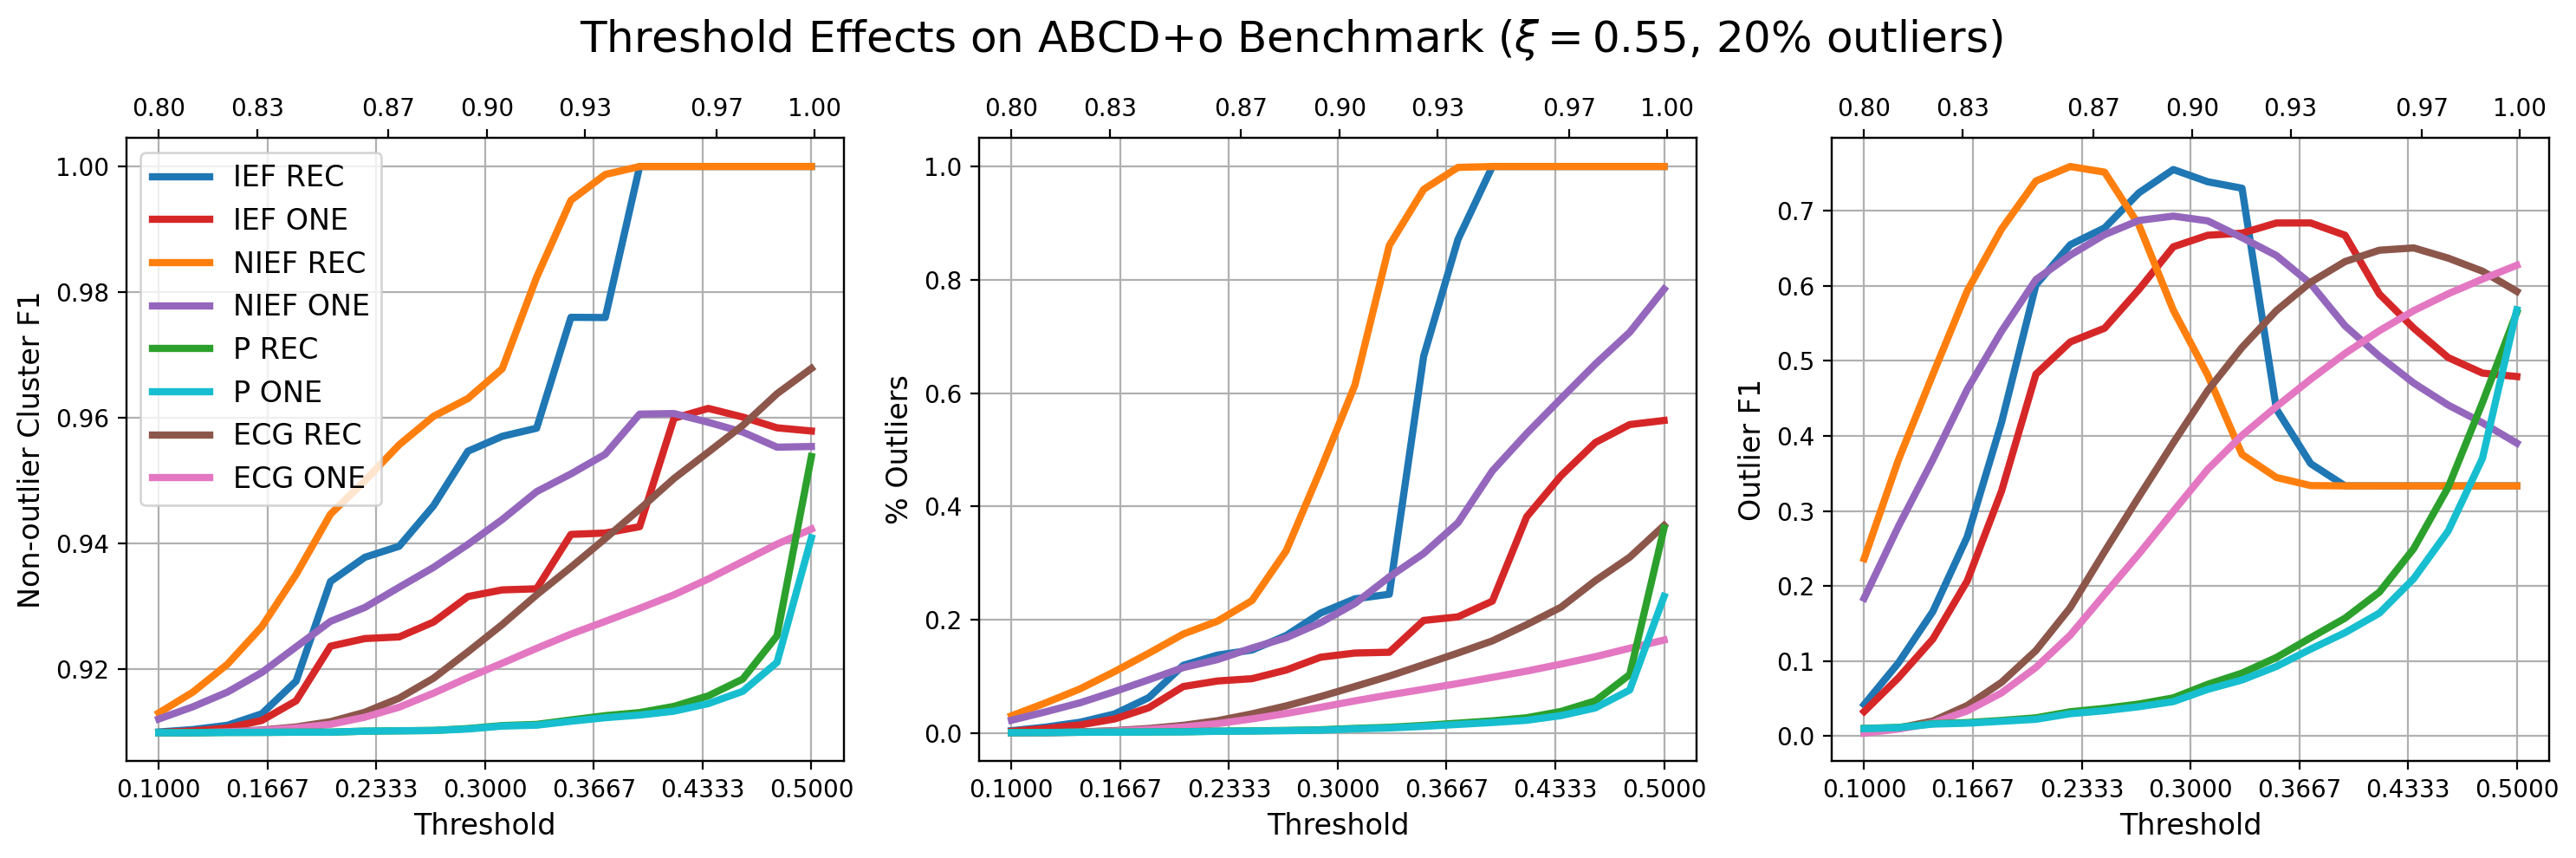

In [18]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:cyan",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
]

fig, axs = plt.subplots(1, 3)
for i in range(3):
    lines = []
    twy = axs[i].twiny()

    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ief[0, i, :, :], axis=1),
        linewidth=3,
        label="IEF REC",
        c=colors[0],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ief[1, i, :, :], axis=1),
        linewidth=3,
        label="IEF ONE",
        c=colors[3],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(nief[0, i, :, :], axis=1),
        linewidth=3,
        label="NIEF REC",
        c=colors[1],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(nief[1, i, :, :], axis=1),
        linewidth=3,
        label="NIEF ONE",
        c=colors[4],
    )
    lines += twy.plot(
        p_thresholds, np.mean(p[0, i, :, :], axis=1), label="P REC", linewidth=3, c=colors[2]
    )
    lines += twy.plot(
        p_thresholds, np.mean(p[1, i, :, :], axis=1), label="P ONE", linewidth=3, c=colors[5]
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ecg[0, i, :, :], axis=1),
        linewidth=3,
        label="ECG REC",
        c=colors[6],
    )
    lines += axs[i].plot(
        ief_thresholds,
        np.mean(ecg[1, i, :, :], axis=1),
        linewidth=3,
        label="ECG ONE",
        c=colors[7],
    )
    labels = [l.get_label() for l in lines]

    # Align tick marks, 5 looks good
    n_ticks = 7
    ief_ticks = np.linspace(np.min(ief_thresholds), np.max(ief_thresholds), n_ticks)
    axs[i].set_xticks(ief_ticks)
    p_ticks = np.round(np.linspace(np.min(p_thresholds), 1, n_ticks), 2)
    twy.set_xticks(p_ticks)
    axs[i].grid()
    #axs[i].set_ylim((-0.01,1.01))

axs[0].set_ylabel("Non-outlier Cluster F1", fontsize=12)
axs[1].set_ylabel("% Outliers", fontsize=12)
axs[2].set_ylabel("Outlier F1", fontsize=12)
axs[0].set_xlabel("Threshold", fontsize=12)
axs[1].set_xlabel("Threshold", fontsize=12)
axs[2].set_xlabel("Threshold", fontsize=12)
axs[0].legend(lines, labels, fontsize=12)
plt.suptitle(
    f"Threshold Effects on ABCD+o Benchmark " + r"$(\xi=0.55$, 20% outliers)",
    fontsize=18,
)

fig = plt.gcf()
fig.set_size_inches(15, 5)
fig.set_dpi(200)
fig.tight_layout()

## 3 heatmaps of threshold vs xi using F1 clustering comparison
(averaged across various proportions of outliers)

In [27]:
REP = 5
n = 10000
NOUTS = np.linspace(n / 100, n / 2, 5, dtype="int32")
XIS = np.array([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7])
ief_thresholds = np.round(np.linspace(0.1, 0.5, 9), 2)
p_thresholds = np.round(np.linspace(0.9, 0.99, 9), 2)

ief_f1s = np.empty((len(XIS), len(ief_thresholds), len(NOUTS), REP))
nief_f1s = np.empty((len(XIS), len(ief_thresholds), len(NOUTS), REP))
p_f1s = np.empty((len(XIS), len(p_thresholds), len(NOUTS), REP))

with tqdm(total=len(NOUTS) * len(XIS) * len(ief_thresholds) * REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                params = ABCDParams(
                    vcount=n,
                    gamma=2.5,
                    min_degree=5,
                    max_degree=int(n**0.5),
                    beta=1.5,
                    min_community_size=50,
                    max_community_size=int(n**0.767),
                    xi=xi,
                    num_outliers=nout,
                )
                G = ABCDGraph(params)
                G.build()
                adjacency = G.exporter.to_sparse_adjacency_matrix()
                labels = np.array(
                    [i for i, com in enumerate(G.communities) for _ in com.vertices]
                )
                labels[labels == np.max(labels)] = -1
                predict = ECG().fit_predict(adjacency)

                for l, (t1, t2) in enumerate(zip(ief_thresholds, p_thresholds)):
                    cas_predict = CAS.CASPostProcesser(
                        score="ief", threshold=t1
                    ).fit_predict(predict, adjacency)
                    ief_f1s[i, l, j, k] = cluster_f1s(labels, cas_predict)

                    cas_predict = CAS.CASPostProcesser(
                        score="nief", threshold=t1
                    ).fit_predict(predict, adjacency)
                    nief_f1s[i, l, j, k] = cluster_f1s(labels, cas_predict)

                    cas_predict = CAS.CASPostProcesser(
                        score="p", threshold=t2
                    ).fit_predict(predict, adjacency)
                    p_f1s[i, l, j, k] = cluster_f1s(labels, cas_predict)

                    pbar.update()

100%|██████████| 2025/2025 [14:31<00:00,  2.32it/s]


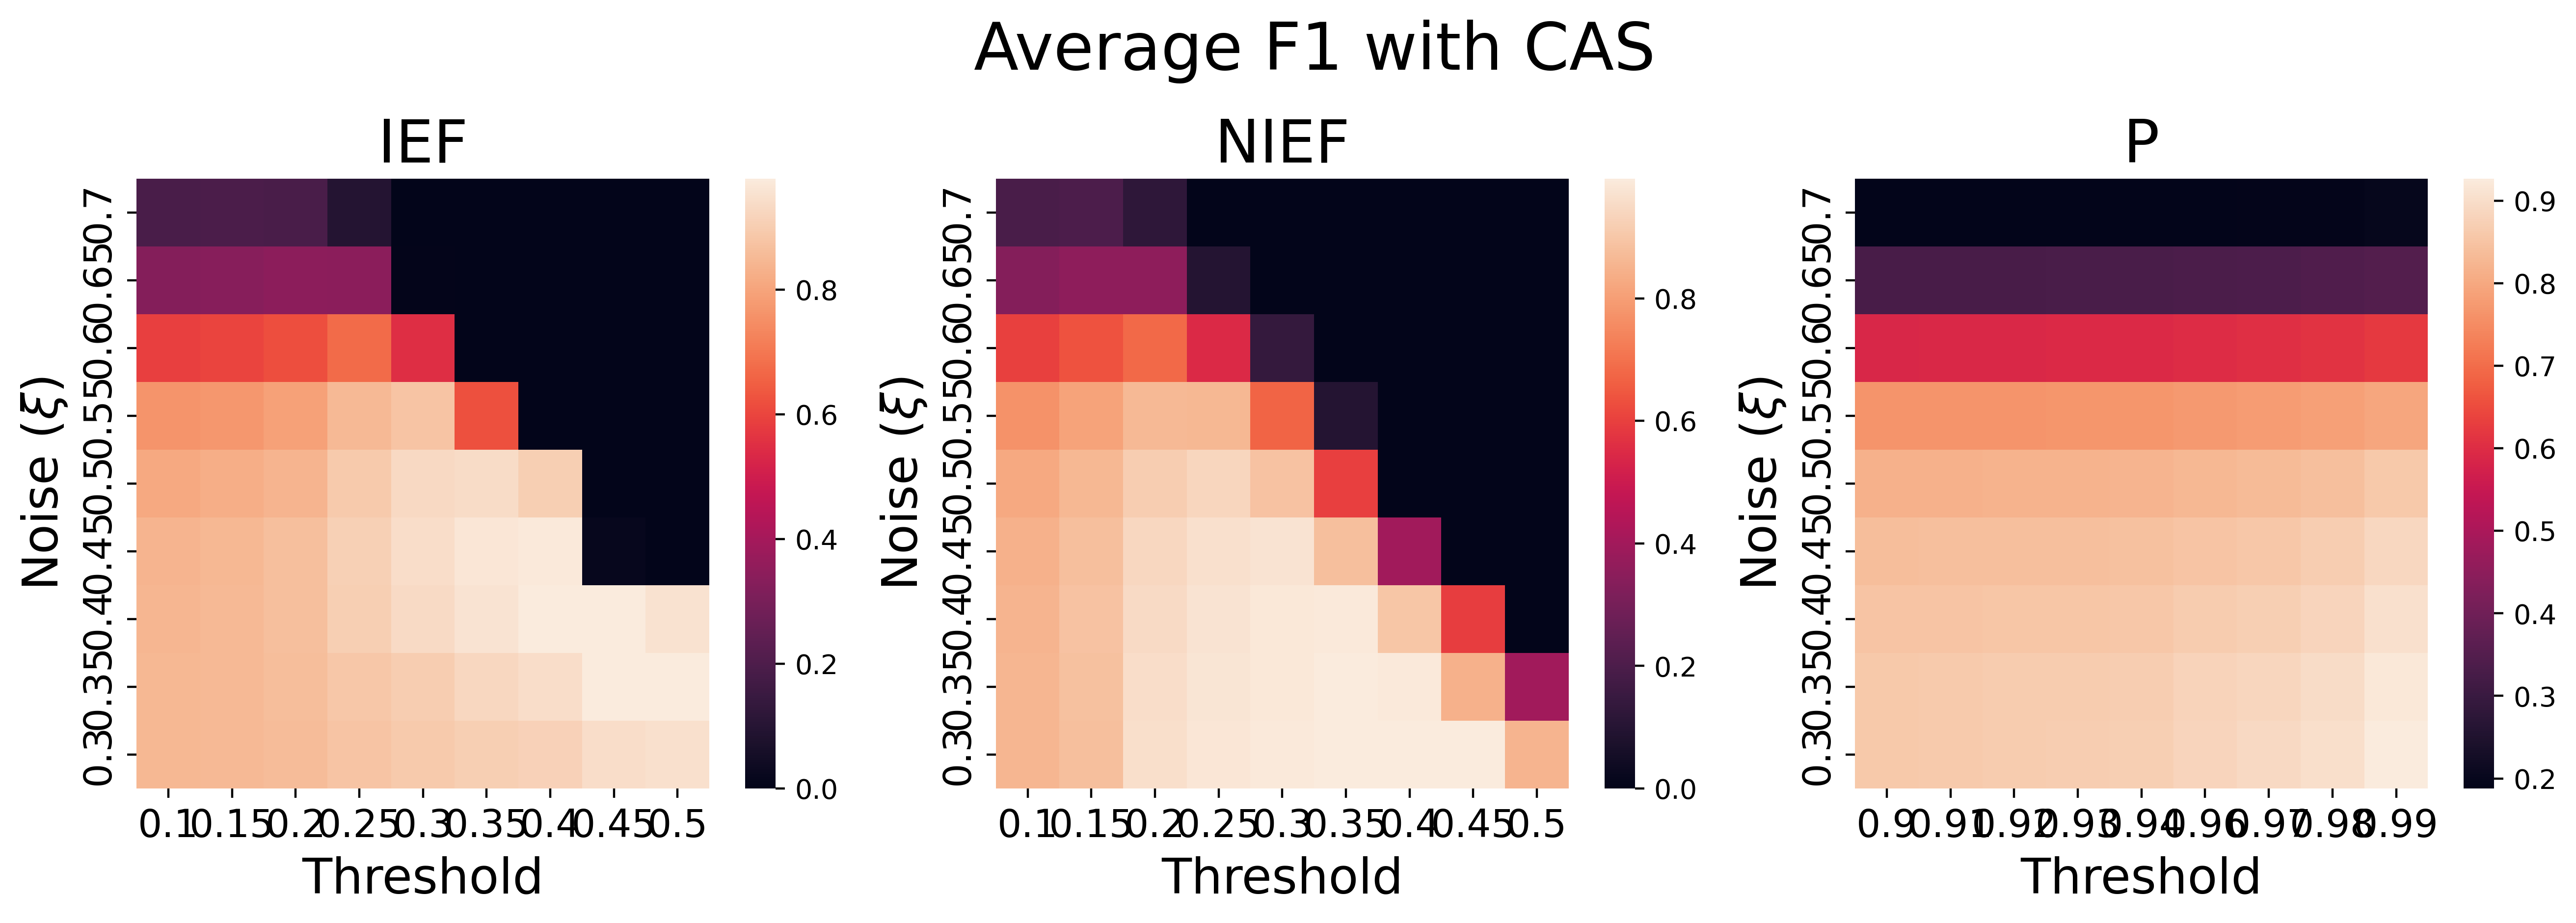

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4.5))
fig.subplots_adjust(top=0.8)  # Make room for suptitle

sns.heatmap(
    np.flip(np.mean(ief_f1s, axis=(2, 3)), axis=0),
    xticklabels=ief_thresholds,
    yticklabels=XIS[::-1],
    #annot=True,
    #fmt=".2f",
    ax=axs[0],
)
axs[0].set_xlabel(r"Threshold", fontsize=18)
axs[0].set_ylabel(r"Noise ($\xi$)", fontsize=18)
axs[0].tick_params(labelsize=14)
axs[0].set_title("IEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(nief_f1s, axis=(2, 3)), axis=0),
    xticklabels=ief_thresholds,
    yticklabels=XIS[::-1],
    #annot=True,
    #fmt=".2f",
    ax=axs[1],
)
axs[1].set_xlabel(r"Threshold", fontsize=18)
axs[1].set_ylabel(r"Noise ($\xi$)", fontsize=18)
axs[1].tick_params(labelsize=14)
axs[1].set_title("NIEF", fontsize=22)

sns.heatmap(
    np.flip(np.mean(p_f1s, axis=(2, 3)), axis=0),
    xticklabels=p_thresholds,
    yticklabels=XIS[::-1],
    #annot=True,
    #fmt=".2f",
    ax=axs[2],
)
axs[2].set_xlabel(r"Threshold", fontsize=18)
axs[2].set_ylabel(r"Noise ($\xi$)", fontsize=18)
axs[2].tick_params(labelsize=14)
axs[2].set_title("P", fontsize=22)

plt.suptitle("Average F1 with CAS", fontsize=24, y=0.98)
fig.set_dpi(400)
# fig.savefig("outlier-aucs.png", bbox_inches="tight")

## Try some real data
- with known outliers (Amazon, DBLP, Youtube, Cora, Football)
- with knwon partitions (eu-email, MNIST/FMNIST, bio-network?)

In [4]:
def load_graph(name):
    adjacency = sp.load_npz(f"data/{name}_adjacency.npz")
    try:
        labels = np.load(f"data/{name}_labels.npy")
    except FileNotFoundError as e:
        try:
            labels = sp.load_npz(f"data/{name}_labels.npz")
        except FileNotFoundError as e:
            raise ValueError("Can't find labels file as npy or npz :(")
    return adjacency, labels

In [20]:
graphs = ["football", "eu-core", "as", "cora", "amazon", "dblp"]
ief_thresholds = np.linspace(0.1, 0.6, 20)
p_thresholds = np.linspace(0.9, 0.999, 20)

# Store (Cluster F1, Non-Outlier Cluster F1, % Outlier) in first axis, theshold in second axis, REP in third axis
ief = np.empty((len(graphs), 3, len(ief_thresholds)))
nief = np.empty((len(graphs),3, len(ief_thresholds)))
ecg = np.empty((len(graphs),3, len(ief_thresholds)))
p = np.empty((len(graphs), 3, len(p_thresholds)))


for i, name in enumerate(graphs):
    print(name)
    adjacency, labels = load_graph(name)
    if sp.issparse(labels):
        is_outlier = labels.getnnz(0) == 0
    else:
        is_outlier = labels == -1
    ecgo = ECG()
    predict = ecgo.fit_predict(adjacency)
    print("CAS PostProcessing")
    with tqdm(total=len(ief_thresholds)) as pbar:
        for j, (t1, t2) in enumerate(zip(ief_thresholds, p_thresholds)):
            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t1).fit_predict(
                predict, adjacency
            )
            ief[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            ief[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            ief[i, 2, j] = np.sum(cas_predict == -1) / len(cas_predict)

            cas_predict = CAS.CASPostProcesser(score="nief", threshold=t1).fit_predict(
                predict, adjacency
            )
            nief[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            nief[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            nief[i, 2, j] = np.sum(cas_predict == -1) / len(cas_predict)


            cas_predict = CAS.CASPostProcesser(score="ief", threshold=t1).fit_predict(
                predict, ecgo.weights
            )
            ecg[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            ecg[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            ecg[i, 2, j] = np.sum(cas_predict == -1) / len(cas_predict)

            cas_predict = CAS.CASPostProcesser(score="p", threshold=t2).fit_predict(
                predict, adjacency
            )
            p[i, 0, j] = ce.cluster_f1s(labels, cas_predict)
            p[i, 1, j] = ce.cluster_f1s(labels, cas_predict, drop_outliers=True)
            p[i, 2, j] = np.sum(cas_predict == -1) / len(cas_predict)

            pbar.update()

football
CAS PostProcessing


100%|██████████| 20/20 [00:00<00:00, 151.11it/s]

eu-core


CAS PostProcessing


100%|██████████| 20/20 [00:00<00:00, 35.45it/s]


as
CAS PostProcessing


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


cora
CAS PostProcessing


100%|██████████| 20/20 [02:34<00:00,  7.74s/it]


amazon
CAS PostProcessing


100%|██████████| 20/20 [07:22<00:00, 22.12s/it]


dblp
CAS PostProcessing


100%|██████████| 20/20 [06:00<00:00, 18.02s/it]


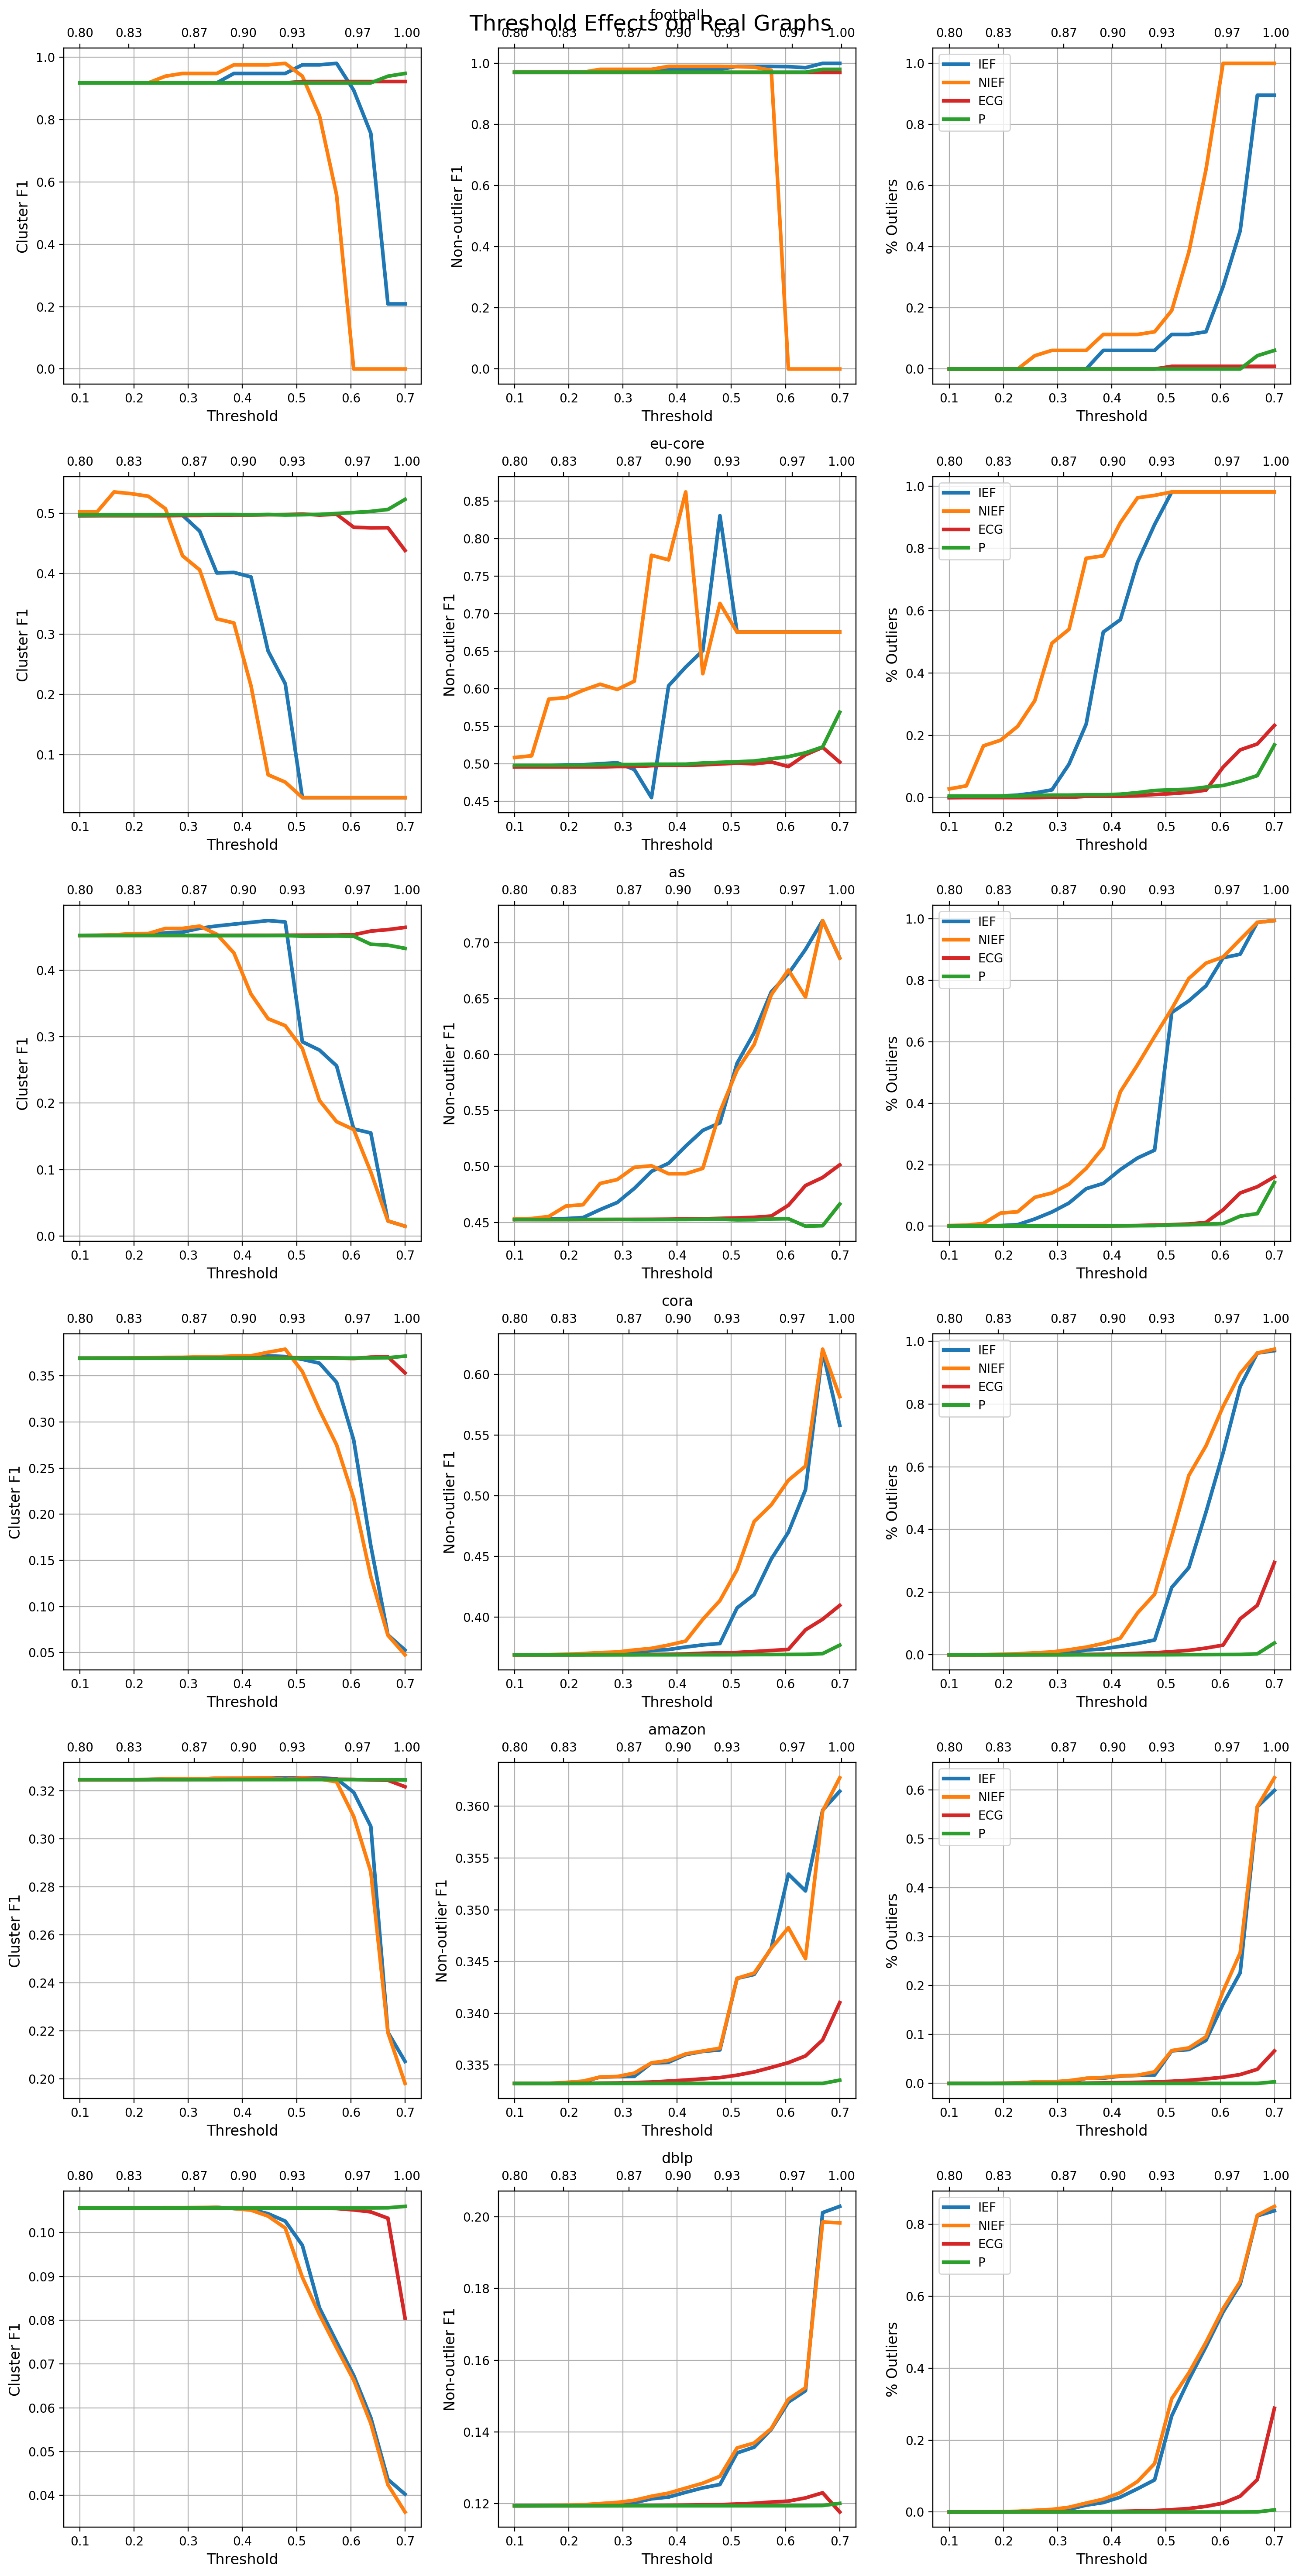

In [21]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

fig, axs = plt.subplots(len(graphs), 3)
fig.subplots_adjust(top=0.9)  # Make room for suptitle
for i in range(len(graphs)):
    for j in range(3):
        lines = []
        twy = axs[i,j].twiny()

        lines += axs[i,j].plot(
            ief_thresholds,
            ief[i, j, :],
            linewidth=3,
            label="IEF",
            c=colors[0],
        )
        lines += axs[i,j].plot(
            ief_thresholds,
            nief[i, j, :],
            linewidth=3,
            label="NIEF",
            c=colors[1],
        )
        lines += axs[i,j].plot(
            ief_thresholds,
            ecg[i, j, :],
            linewidth=3,
            label="ECG",
            c=colors[3],
        )
        lines += twy.plot(
            p_thresholds, p[i, j, :], label="P", linewidth=3, c=colors[2]
        )
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 7
        ief_ticks = np.linspace(np.min(ief_thresholds), np.max(ief_thresholds), n_ticks)
        axs[i,j].set_xticks(ief_ticks)
        p_ticks = np.round(np.linspace(np.min(p_thresholds), 1, n_ticks), 2)
        twy.set_xticks(p_ticks)
        axs[i,j].grid()
        #axs[i,j].set_ylim((0,1))

    axs[i,0].set_ylabel("Cluster F1", fontsize=12)
    axs[i,1].set_ylabel("Non-outlier F1", fontsize=12)
    axs[i,2].set_ylabel("% Outliers", fontsize=12)
    axs[i,0].set_xlabel("Threshold", fontsize=12)
    axs[i,1].set_xlabel("Threshold", fontsize=12)
    axs[i,2].set_xlabel("Threshold", fontsize=12)
    axs[i,2].legend(lines, labels)
    axs[i,1].set_title(graphs[i])
plt.suptitle(
    f"Threshold Effects on Real Graphs",
    fontsize=18,
)
fig = plt.gcf()
fig.set_size_inches(15, 5*len(graphs))
fig.set_dpi(200)
fig.tight_layout()

## Evaluate Cluster Specific metrics before and after CAS for a specific threshold

In [11]:
t = 0.5
graphs = ["football", "eu-core", "as", "cora", "amazon", "dblp"]
data = np.empty((len(graphs), 6, 5))
for i, name in enumerate(graphs):
    print(name)
    adjacency, labels = load_graph(name)
    ecgo = ECG()
    predict = CAS.labels_array_to_matrix(ecgo.fit_predict(adjacency))
    predict_conductance = np.nanmean(ce.conductance(adjacency, predict))
    predict_cc = np.nanmean(ce.clustering_coefficient(adjacency, predict))
    predict_density = np.nanmean(ce.density(adjacency, predict))
    predict_expansion = np.nanmean(ce.expansion(adjacency, predict))
    predict_modularity = np.nanmean(ce.modularity(adjacency, predict))

    ief_rec = CAS.CASPostProcesser(score="ief", threshold=t).fit_predict(predict, adjacency)
    ief_one = CAS.CASPostProcesser(score="ief", threshold=t, max_rounds=1).fit_predict(predict, adjacency)

    nief_rec = CAS.CASPostProcesser(score="nief", threshold=t).fit_predict(predict, adjacency)
    nief_one = CAS.CASPostProcesser(score="nief", threshold=t, max_rounds=1).fit_predict(predict, adjacency)

    ecg_rec = CAS.CASPostProcesser(score="ief", threshold=t).fit_predict(predict, adjacency)
    ecg_one = CAS.CASPostProcesser(score="ief", threshold=t, max_rounds=1).fit_predict(predict, ecgo.weights)

    for j, cas in enumerate([ief_rec, ief_one, nief_rec, nief_one, ecg_rec, ecg_one]):
        cas_conductance = np.nanmean(ce.conductance(adjacency, cas))
        cas_cc = np.nanmean(ce.clustering_coefficient(adjacency, cas))
        cas_density = np.nanmean(ce.density(adjacency, cas))
        cas_expansion = np.nanmean(ce.expansion(adjacency, cas))
        cas_modularity = np.nanmean(ce.modularity(adjacency, cas))

        data[i,j,0] = cas_density - predict_density
        data[i,j,1] = cas_cc - predict_cc
        data[i,j,2] = cas_modularity - predict_modularity
        data[i,j,3] = cas_conductance - predict_conductance
        data[i,j,4] = cas_expansion - predict_expansion

football
eu-core
as
cora
amazon
dblp


In [12]:
print(f"         | Density |   CC   | Modularity | Conductance | Expansion ")
for j, score in enumerate(["IEF REC", "IEF ONE", "NIEF REC", "NIEF ONE", "ECG REC", "ECG ONE"]):
    print()
    print(f"{score:.14s}")
    for i, name in enumerate(graphs):
        print(f"{name:8s} | {data[i, j, 0]:7.3f} | {data[i, j, 1]:6.3f} | {data[i, j, 2]:10.3f} | {data[i, j, 3]:11.3f} | {data[i, j, 4]:9.3f}")

         | Density |   CC   | Modularity | Conductance | Expansion 

IEF REC
football |   0.025 |  0.024 |     -0.001 |      -0.003 |    -0.015
eu-core  |  -0.004 | -0.181 |     -0.003 |      -0.049 |    -3.502
as       |   0.001 |  0.001 |     -0.001 |      -0.028 |    -0.280
cora     |   0.001 |  0.013 |     -0.000 |      -0.005 |    -0.056
amazon   |   0.000 |  0.001 |     -0.000 |      -0.002 |    -0.013
dblp     |   0.000 |  0.014 |     -0.000 |      -0.011 |    -0.092

IEF ONE
football |   0.015 |  0.016 |     -0.000 |      -0.000 |     0.005
eu-core  |  -0.014 | -0.055 |     -0.001 |       0.014 |    -0.726
as       |   0.000 |  0.002 |     -0.001 |      -0.007 |    -0.177
cora     |   0.000 |  0.006 |     -0.000 |      -0.003 |    -0.040
amazon   |   0.000 |  0.001 |     -0.000 |      -0.002 |    -0.010
dblp     |   0.000 |  0.006 |     -0.000 |      -0.004 |    -0.051

NIEF REC
football |   0.043 |  0.029 |     -0.001 |      -0.006 |    -0.033
eu-core  |     nan |    nan |    